In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns; sns.set()

In [2]:
trips = pd.read_csv('2015_trip_data.csv',
                    parse_dates=['starttime', 'stoptime'],
                    infer_datetime_format=True)

In [3]:
ind = pd.DatetimeIndex(trips.starttime)
trips['date'] = ind.date.astype('datetime64')
trips['hour'] = ind.hour

In [4]:
hourly = trips.pivot_table('trip_id', aggfunc='count',
                           index=['usertype', 'date'], columns='hour').fillna(0)
hourly.head()

hour                      0   1   2   3   4   5   6   7   8   9  ...  14  15  \
usertype      date                                               ...           
Annual Member 2014-10-13   0   0   0   0   0   0   0   0   0   0 ...  32  23   
              2014-10-14   0   0   0   0   0   1   4  16  28  13 ...  13  16   
              2014-10-15   1   0   0   0   0   0   5   7  11  16 ...   7  10   
              2014-10-16   2   1   0   0   0   2   6   8  27  19 ...   8  10   
              2014-10-17   1   0   1   0   0   1   4  13  20  19 ...   3   5   

hour                      16  17  18  19  20  21  22  23  
usertype      date                                        
Annual Member 2014-10-13  23  28  21   8  11   9   3   1  
              2014-10-14  19  28  25  14   8  10   1   2  
              2014-10-15  32  33  15  15   9   9   2   1  
              2014-10-16  27  40  20  17   6   6   3   4  
              2014-10-17  17  17  20  10   5  10   2   1  

[5 rows x 24 columns]

## Principal Component Analysis

In [5]:
from sklearn.decomposition import PCA
data = hourly[np.arange(24)].values
data_pca = PCA(2).fit_transform(data)
hourly['projection1'], hourly['projection2'] = data_pca.T

In [6]:
hourly['total rides'] = hourly.sum(axis=1)

/Users/jakevdp/anaconda/envs/python3.4/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


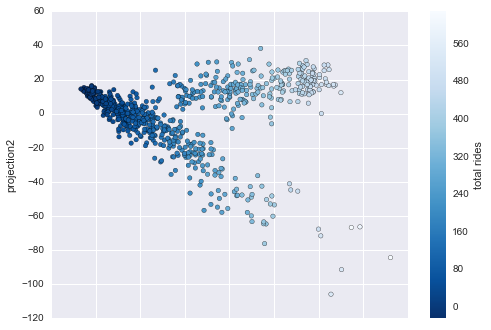

In [7]:
hourly.plot('projection1', 'projection2', kind='scatter', c='total rides', cmap='Blues_r');

plt.savefig('figs/pca_raw.png', bbox_inches='tight')

## Automated Clustering

In [8]:
from sklearn.mixture import GMM
gmm = GMM(3, covariance_type='full', random_state=2)
data = hourly[['projection1', 'projection2']]
gmm.fit(data)

# require high-probability cluster membership
hourly['cluster'] = (gmm.predict_proba(data)[:, 0] > 0.6).astype(int)

/Users/jakevdp/anaconda/envs/python3.4/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


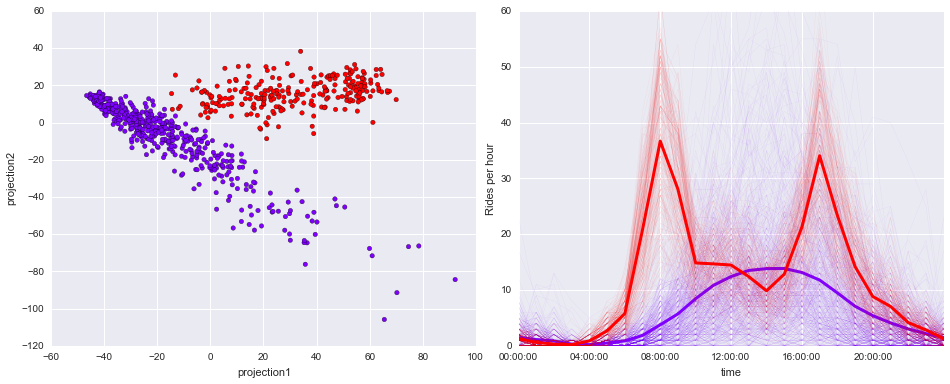

In [9]:
from datetime import time
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(wspace=0.1)
times = pd.date_range('0:00', '23:59', freq='H').time
times = np.hstack([times, time(23, 59, 59)])

hourly.plot('projection1', 'projection2', c='cluster', kind='scatter', 
            cmap='rainbow', colorbar=False, ax=ax[0]);

for i in range(2):
    vals = hourly.query("cluster == " + str(i))[np.arange(24)]
    vals[24] = vals[0]
    ax[1].plot(times, vals.T, color=plt.cm.rainbow(255 * i), alpha=0.05, lw=0.5)
    ax[1].plot(times, vals.mean(0), color=plt.cm.rainbow(255 * i), lw=3)
    ax[1].set_xticks(4 * 60 * 60 * np.arange(6))
    
ax[1].set_ylim(0, 60);
ax[1].set_ylabel('Rides per hour');

fig.savefig('figs/pca_clustering.png', bbox_inches='tight')

/Users/jakevdp/anaconda/envs/python3.4/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


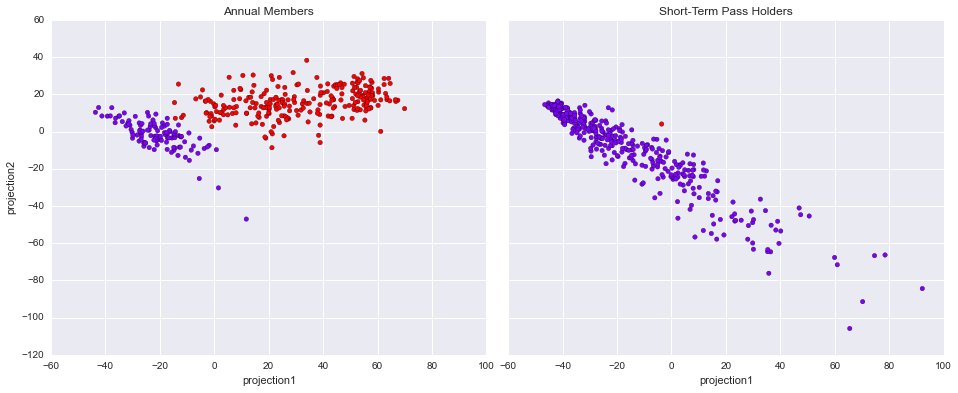

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0.05)

for i, col in enumerate(['Annual Member', 'Short-Term Pass Holder']):
    hourly.loc[col].plot('projection1', 'projection2',  c='cluster', kind='scatter', 
                         cmap='rainbow', colorbar=False, ax=ax[i]);
    ax[i].set_title(col + 's')
    
fig.savefig('figs/pca_annual_vs_shortterm.png', bbox_inches='tight')

/Users/jakevdp/anaconda/envs/python3.4/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


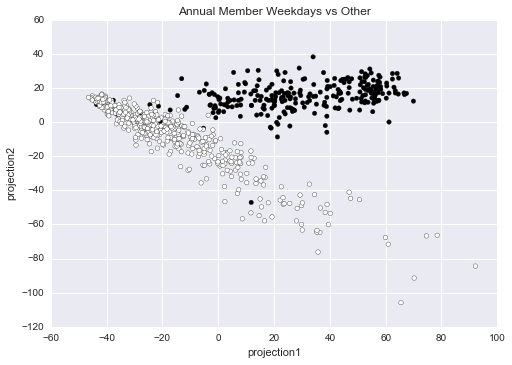

In [11]:
usertype = hourly.index.get_level_values('usertype')
weekday = hourly.index.get_level_values('date').dayofweek < 5
hourly['commute'] = (weekday & (usertype == "Annual Member"))

fig, ax = plt.subplots()

hourly.plot('projection1', 'projection2', c='commute', kind='scatter', 
            cmap='binary', colorbar=False, ax=ax);

ax.set_title("Annual Member Weekdays vs Other")

fig.savefig('figs/pca_true_weekends.png', bbox_inches='tight')

## Identifying Mismatches

In [12]:
mismatch = hourly.query('cluster == 0 & commute')
mismatch = mismatch.reset_index('usertype')[['usertype', 'projection1', 'projection2']]
mismatch

hour,usertype,projection1,projection2
date,,,
2014-10-13,Annual Member,11.801941,-47.055049
2014-11-27,Annual Member,-39.257659,8.284703
2014-11-28,Annual Member,-37.617643,12.843594
2014-12-23,Annual Member,-21.424691,9.384624
2014-12-24,Annual Member,-22.459886,4.800410
2014-12-25,Annual Member,-43.631130,10.346482
2014-12-26,Annual Member,-27.541947,4.615430
2014-12-31,Annual Member,-24.510922,10.280756
2015-01-01,Annual Member,-36.385406,4.758340


In [13]:
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays('2014-08', '2015-10', return_name=True)
holidays_all = pd.concat([holidays,
                          "2 Days Before " + holidays.shift(-2, 'D'),
                          "Day Before " + holidays.shift(-1, 'D'),
                          "Day After " + holidays.shift(1, 'D')])
holidays_all = holidays_all.sort_index()
holidays_all.head()

2014-08-30       2 Days Before Labor Day
2014-08-31          Day Before Labor Day
2014-09-01                     Labor Day
2014-09-02           Day After Labor Day
2014-10-11    2 Days Before Columbus Day
dtype: object

In [14]:
holidays_all.name = 'holiday name'  # required for join
joined = mismatch.join(holidays_all)
joined['holiday name']

date
2014-10-13                Columbus Day
2014-11-27                Thanksgiving
2014-11-28      Day After Thanksgiving
2014-12-23     2 Days Before Christmas
2014-12-24        Day Before Christmas
2014-12-25                   Christmas
2014-12-26         Day After Christmas
2014-12-31    Day Before New Years Day
2015-01-01               New Years Day
2015-01-02     Day After New Years Day
2015-05-25                 MemorialDay
2015-07-03                    July 4th
2015-09-07                   Labor Day
Name: holiday name, dtype: object

In [15]:
set(holidays) - set(joined['holiday name'])

{'Dr. Martin Luther King Jr.', 'Presidents Day', 'Veterans Day'}

/Users/jakevdp/anaconda/envs/python3.4/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


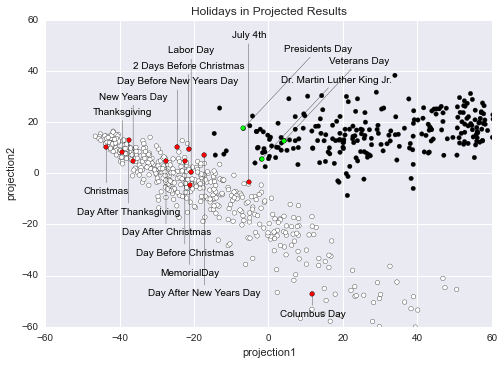

In [16]:
fig, ax = plt.subplots()

hourly.plot('projection1', 'projection2', c='cluster', kind='scatter', 
            cmap='binary', colorbar=False, ax=ax);

ax.set_title("Holidays in Projected Results")

for i, ind in enumerate(joined.sort_values('projection1').index):
    x, y = hourly.loc['Annual Member', ind][['projection1', 'projection2']]
    if i % 2:
        ytext = 20 + 3 * i
    else:
        ytext = -8 - 4 * i
    ax.annotate(joined.loc[ind, 'holiday name'], [x, y], [x , ytext], color='black',
                ha='center', arrowprops=dict(arrowstyle='-', color='black'))
    ax.scatter([x], [y], c='red')
    
for holiday in (set(holidays) - set(joined['holiday name'])):
    ind = holidays[holidays == holiday].index[0]
    #ind = ind.strftime('%Y-%m-%d')
    x, y = hourly.loc['Annual Member', ind][['projection1', 'projection2']]
    ax.annotate(holidays.loc[ind], [x, y], [x + 20, y + 30], color='black',
                ha='center', arrowprops=dict(arrowstyle='-', color='black'))
    ax.scatter([x], [y], c='#00FF00')

ax.set_xlim([-60, 60])
ax.set_ylim([-60, 60])

fig.savefig('figs/pca_holiday_labels.png', bbox_inches='tight')